### GAUSSIAN MIXTURE MODEL

#### Assignment 1

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [3]:
# Gaussian PDF
def gaussian_pdf(x, mean, cov):
    D = x.shape[1]
    cov_inv = np.linalg.inv(cov)
    diff = x - mean
    exponent = np.einsum('ij,jk,ik->i', diff, cov_inv, diff)
    denom = np.sqrt((2 * np.pi) ** D * np.linalg.det(cov))
    return np.exp(-0.5 * exponent) / denom

In [4]:
# Initialization
def initialize_parameters(X, K):
    N, D = X.shape
    mu = X[np.random.choice(N, K, replace=False)]
    cov = np.array([np.cov(X.T) + 1e-6 * np.eye(D) for _ in range(K)])
    pi = np.ones(K) / K
    return mu, cov, pi

In [5]:
# E-step
def e_step(X, mu, cov, pi):
    N, K = X.shape[0], len(pi)
    gamma = np.zeros((N, K))
    for k in range(K):
        gamma[:, k] = pi[k] * gaussian_pdf(X, mu[k], cov[k])
    gamma /= gamma.sum(axis=1, keepdims=True)
    return gamma

In [6]:
# M-step
def m_step(X, gamma):
    N, D = X.shape
    K = gamma.shape[1]
    N_k = gamma.sum(axis=0)
    mu = np.dot(gamma.T, X) / N_k[:, None]
    cov = np.zeros((K, D, D))
    for k in range(K):
        diff = X - mu[k]
        cov[k] = (gamma[:, k, None] * diff).T @ diff / N_k[k]
        cov[k] += 1e-6 * np.eye(D)  # Regularization
    pi = N_k / N
    return mu, cov, pi

In [7]:
# GMM training
def gmm_train(X, K, iterations=100):
    mu, cov, pi = initialize_parameters(X, K)
    for _ in range(iterations):
        gamma = e_step(X, mu, cov, pi)
        mu, cov, pi = m_step(X, gamma)
    return mu, cov, pi, gamma

In [11]:
# Tạo dữ liệu giả lập gồm 3 cụm
X, y_true = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=0)

In [28]:
# Huấn luyện GMM với code đã cài
mu1, cov1, pi1, gamma1 = gmm_train(X, K=3)

In [29]:
# Dự đoán nhãn
labels = np.argmax(gamma1, axis=1)

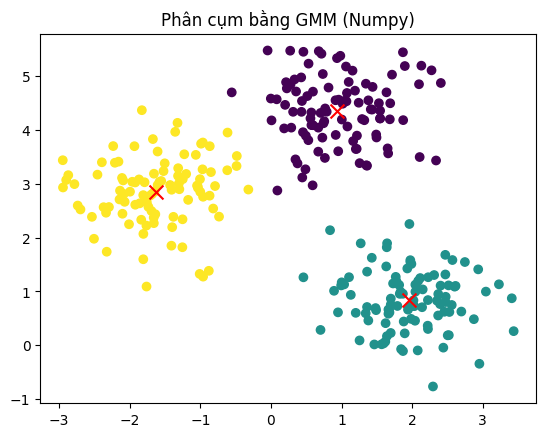

In [30]:
# Vẽ kết quả phân cụm
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.scatter(mu1[:, 0], mu1[:, 1], c='red', s=100, marker='x')
plt.title("Phân cụm bằng GMM (Numpy)")
plt.show()

In [26]:
# Đọc ảnh đen trắng
img = cv2.imread(cv2.samples.findFile('D:\kitten.jpg'), cv2.IMREAD_GRAYSCALE)
img_flat = img.reshape(-1, 1).astype(np.float64)


In [31]:
# Huấn luyện GMM
mu2, cov2, pi2, gamma2 = gmm_train(img_flat, K=3)

In [32]:
# Dự đoán cụm pixel
labels = np.argmax(gamma2, axis=1).reshape(img.shape)

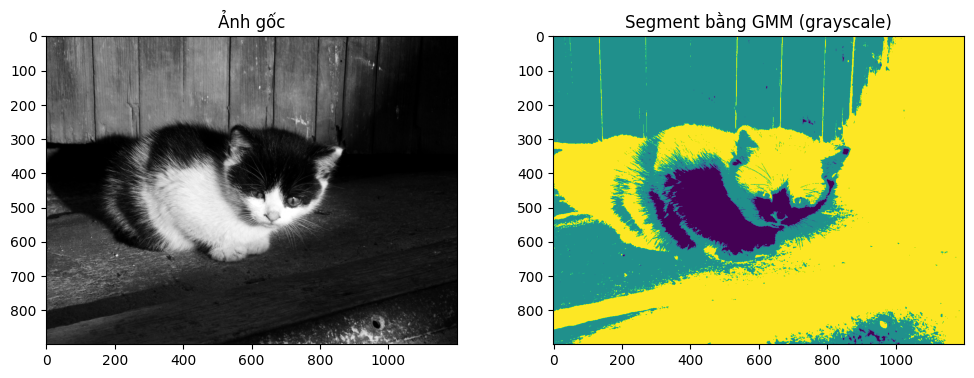

In [33]:
# Hiển thị
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Ảnh gốc")
plt.imshow(img, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Segment bằng GMM (grayscale)")
plt.imshow(labels, cmap='viridis')
plt.show()

### Assignment 2

In [8]:
def segment_image(image_path, K=3):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, c = img_rgb.shape
    pixels = img_rgb.reshape(-1, 3).astype(np.float64)

    mu, cov, pi, gamma = gmm_train(pixels, K)
    labels = np.argmax(gamma, axis=1)
    bg_label = np.bincount(labels).argmax()

    mask = (labels != bg_label).astype(np.uint8).reshape(h, w)
    output = img_rgb.copy()
    output[mask == 0] = [255, 255, 255]

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(output)
    plt.title("Foreground Extracted")
    plt.axis("off")
    plt.show()

    return output

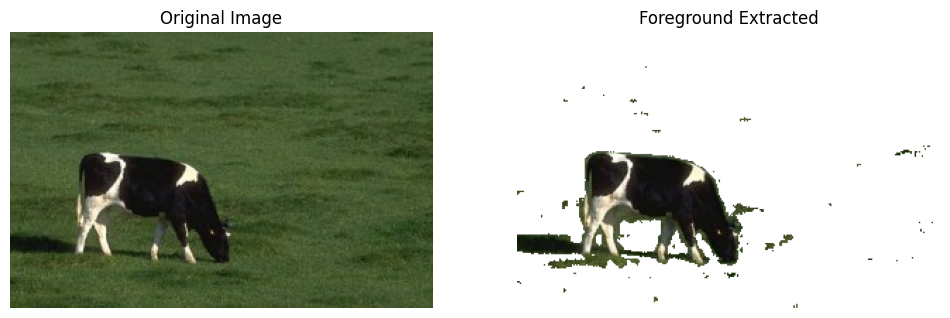

In [24]:
output = segment_image("D:\cow.jpg", K=3)

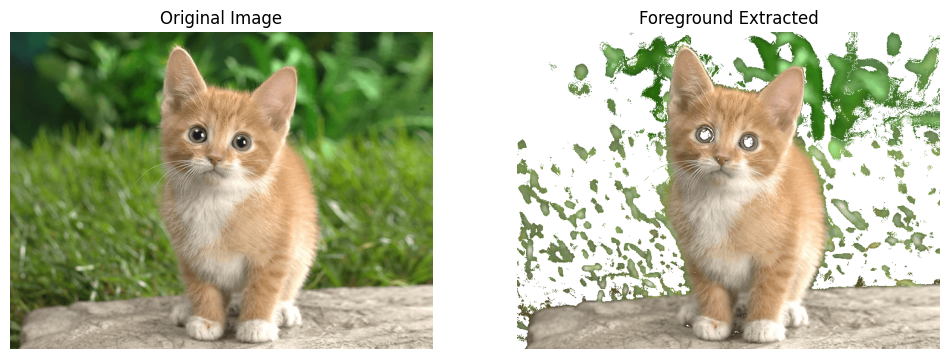

In [35]:
output1 = segment_image('D:\cat.png', K=3)